In [12]:
%matplotlib inline
%load_ext autoreload

import matplotlib.pyplot as plt

import sys
sys.path.append("/home/ubuntu/Notebooks/annsa/")

import seaborn as sn
import annsa as an
import tensorflow as tf
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Spectra dataset
#### Dataset needs to be provided

In [2]:
training_data = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/spectrum_data_1-simplex_1E6.npy')[:-10000]
training_key  = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/key_data_1-simplex_1E6.npy')[:-10000]

testing_data  = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/spectrum_data_1-simplex_1E6.npy')[-10000:]
testing_key   = np.load('/home/ubuntu/Notebooks/GADRAS_ANN_work/Project_SORMA18/Dataset_Details/key_data_1-simplex_1E6.npy')[-10000:]


#### Normalize dataset keys

In [3]:
testing_key_normalized  = an.normalize_data(testing_key)
training_key_normalized = an.normalize_data(training_key)

#### Apply LLD and log-normalize spectra

In [4]:
training_data[:,0:10] = 0
testing_data[:,0:10]  = 0

training_data_normalized = an.log_normalize(training_data)
testing_data_normalized  = an.log_normalize(testing_data)

#### Choose ANN parameters, 

In [5]:
layer_1_nodes = 449
layer_2_nodes = 205
layer_3_nodes = 0
layer_4_nodes = 0
scale_factor  = 0.108734027364
learning_rate = 0.0045516536625
keep_prob     = 0.959690346532
dropout_rate  = keep_prob 
optimizer     = 'Adam',
batch_size    = 810



temp_network_details = an.ANN_structure_details(
             layer_1_nodes = layer_1_nodes,
             layer_2_nodes = layer_2_nodes,
             layer_3_nodes = layer_3_nodes,
             layer_4_nodes = layer_4_nodes,
             learning_rate = learning_rate,
             dropout_rate = dropout_rate,
             optimizer = 'Adam',
             scale_factor = scale_factor,
             spectra_length=1024,
             num_categories=32,
             batch_size = batch_size)



train_step, L2_Reg, cross_entropy, x_spectra, y_, keep_prob, ANN_full = an.make_ANN_structure(temp_network_details)

#### Train the ANN

In [8]:
# initialize variables 
training_data = training_data_normalized
training_key  = training_key_normalized
testing_data  = testing_data_normalized
testing_key   = testing_key_normalized
my_ANN_strucutre = temp_network_details
iters = 1000


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
all_vars = tf.global_variables()
saver = tf.train.Saver(all_vars)

def get_error_on_dataset(data,key):
    return sess.run(cross_entropy, 
                feed_dict={
                        x_spectra: data,
                        y_:        key,
                        keep_prob: 1.0})


loss_train        = np.zeros(iters)
loss_test         = np.zeros(iters)
L2_all            = np.zeros(iters)

start_remove_flag = False

for i in range(iters):

    batch_indicies = np.random.choice(range(training_data.shape[0]), my_ANN_strucutre.batch_size, replace=False)
    batch_indicies_for_loss_function = np.random.choice(range(training_data.shape[0]), 900, replace=False)

    train_step.run( 
                    feed_dict = {
                            x_spectra: training_data[batch_indicies],
                            y_:        training_key[batch_indicies], 
                                       keep_prob: my_ANN_strucutre.dropout_rate} )   


    loss_train[i] = get_error_on_dataset(training_data[batch_indicies_for_loss_function],
                                         training_key_normalized[batch_indicies_for_loss_function])

    loss_test[i] = get_error_on_dataset(testing_data,
                                         testing_key_normalized)

    L2_all[i] = sess.run(L2_Reg)


    print '\1b[2k\r',    
    print('Epoch %s of %s, train error is %s, test error is %s' %(i,iters,(loss_train-L2_all)[i], (loss_test-L2_all)[i])),

loss_train = (loss_train-L2_all)[0:i]
loss_test = (loss_test-L2_all)[0:i]


L2_all = L2_all[0:i]



/home/ubuntu/anaconda2/lib/python2.7/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 999 of 1000, train error is 1.0303771905601025, test error is 1.0575402192771435


/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


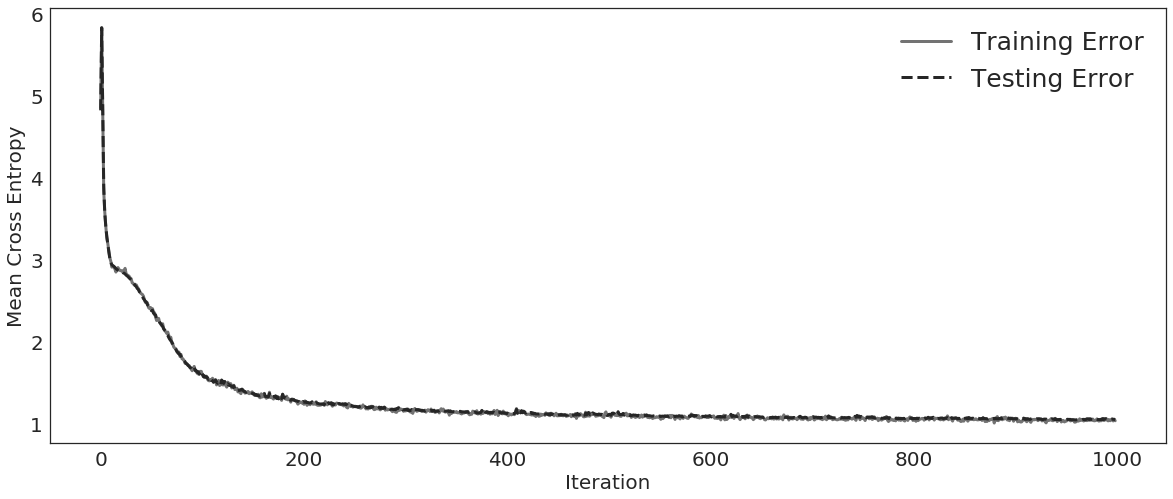

In [13]:
sn.set_style("white")

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(20,8)) 
plt.plot((loss_train)[0:], label='Training Error', linewidth=3.0, color = '0.45')
plt.plot((loss_test)[0:] ,'--', label='Testing Error' , linewidth=3.0, color = '0.15')

plt.ylabel('Mean Cross Entropy',fontsize=20)
plt.xlabel('Iteration',fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)
#plt.ylim([1.5,3.5])
#plt.xlim([0,550])
plt.legend(fontsize=25)
